# 如何使用ToolNode调用工具

本指南介绍了如何使用 LangGraph 的预构建 [`ToolNode`](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html) 进行工具调用。

`ToolNode` 是一个 LangChain Runnable，它将图形状态（带有消息列表）作为输入，并使用工具调用的结果输出状态更新。它被设计为与 LangGraph 的预构建 ReAct 代理开箱即用，但也可以与任何 `StateGraph` 一起使用，只要其状态具有带有适当减速器的 `messages` 键（请参阅 [`MessagesAnnotation`](/langgraphjs/concepts/low_level/#messagesannotation)）。

## 设置
```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core zod
```
设置环境变量：
```typescript
process.env.ANTHROPIC_API_KEY = 'your-anthropic-api-key';
```

## 定义工具

In [1]:
import { tool } from '@langchain/core/tools';
import { z } from 'zod';

const getWeather = tool((input) => {
  if (['sf', 'san francisco'].includes(input.location.toLowerCase())) {
    return 'It\'s 60 degrees and foggy.';
  } else {
    return 'It\'s 90 degrees and sunny.';
  }
}, {
  name: 'get_weather',
  description: 'Call to get the current weather.',
  schema: z.object({
    location: z.string().describe("Location to get the weather for."),
  })
})

const getCoolestCities = tool(() => {
  return 'nyc, sf';
}, {
  name: 'get_coolest_cities',
  description: 'Get a list of coolest cities',
  schema: z.object({
    noOp: z.string().optional().describe("No-op parameter."),
  })
})

In [2]:
import { ToolNode } from '@langchain/langgraph/prebuilt';

const tools = [getWeather, getCoolestCities]
const toolNode = new ToolNode(tools)

## 手动调用`ToolNode`

`ToolNode` 使用消息列表对图形状态进行操作。它期望列表中的最后一条消息是带有 `tool_calls` 参数的 `AIMessage`。

我们先看看如何手动调用工具节点：

In [3]:
import { AIMessage } from '@langchain/core/messages';

const messageWithSingleToolCall = new AIMessage({
  content: "",
  tool_calls: [
    {
      name: "get_weather",
      args: { location: "sf" },
      id: "tool_call_id",
      type: "tool_call",
    }
  ]
})

await toolNode.invoke({ messages: [messageWithSingleToolCall] })

{
  messages: [
    ToolMessage {
      "content": "It's 60 degrees and foggy.",
      "name": "get_weather",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "tool_call_id"
    }
  ]
}


请注意，通常不需要手动创建`AIMessage`，任何支持工具调用的LangChain聊天模型都会自动生成它。

如果将多个工具调用传递给 `AIMessage` 的 `tool_calls` 参数，您还可以使用 `ToolNode` 进行并行工具调用：

In [4]:
const messageWithMultipleToolCalls = new AIMessage({
  content: "",
  tool_calls: [
    {
      name: "get_coolest_cities",
      args: {},
      id: "tool_call_id",
      type: "tool_call",
    },
    {
      name: "get_weather",
      args: { location: "sf" },
      id: "tool_call_id_2",
      type: "tool_call",
    }
  ]
})

await toolNode.invoke({ messages: [messageWithMultipleToolCalls] })

{
  messages: [
    ToolMessage {
      "content": "nyc, sf",
      "name": "get_coolest_cities",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "tool_call_id"
    },
    ToolMessage {
      "content": "It's 60 degrees and foggy.",
      "name": "get_weather",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "tool_call_id_2"
    }
  ]
}


## 与聊天模型一起使用

在我们的示例中，我们将使用 Anthropic 的小型聊天模型。要将聊天模型与工具调用一起使用，我们需要首先确保模型知道可用的工具。我们通过在 `ChatAnthropic` 模型上调用 `.bindTools` 方法来做到这一点

In [5]:
import { ChatAnthropic } from "@langchain/anthropic";

const modelWithTools = new ChatAnthropic({
  model: "claude-3-haiku-20240307",
  temperature: 0
}).bindTools(tools);

In [6]:
const responseMessage = await modelWithTools.invoke("what's the weather in sf?");

responseMessage.tool_calls;

[
  {
    name: 'get_weather',
    args: { location: 'sf' },
    id: 'toolu_01UAjv9Mmj9LRosAsrgKtqeR',
    type: 'tool_call'
  }
]


如您所见，聊天模型生成的 AI 消息已经填充了 `tool_calls`，因此我们可以将其直接传递给 `ToolNode`

In [7]:
await toolNode.invoke({ messages: [await modelWithTools.invoke("what's the weather in sf?")] })

{
  messages: [
    ToolMessage {
      "content": "It's 60 degrees and foggy.",
      "name": "get_weather",
      "additional_kwargs": {},
      "response_metadata": {},
      "tool_call_id": "toolu_01HrJmUek2ninxDiLJrYpDpz"
    }
  ]
}


## 反应代理

接下来，让我们看看如何在 LangGraph 图中使用 `ToolNode`。让我们设置 [ReAct 代理](/langgraphjs/concepts/agentic_concepts/#react-agent) 的图形实现。该代理将一些查询作为输入，然后重复调用工具，直到有足够的信息来解决查询。我们将使用 `ToolNode` 和人择模型以及我们刚刚定义的工具

In [8]:
import {
  StateGraph,
  MessagesAnnotation,
  END,
  START
} from "@langchain/langgraph";

const toolNodeForGraph = new ToolNode(tools)

const shouldContinue = (state: typeof MessagesAnnotation.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1];
  if ("tool_calls" in lastMessage && Array.isArray(lastMessage.tool_calls) && lastMessage.tool_calls?.length) {
      return "tools";
  }
  return END;
}

const callModel = async (state: typeof MessagesAnnotation.State) => {
  const { messages } = state;
  const response = await modelWithTools.invoke(messages);
  return { messages: response };
}


const workflow = new StateGraph(MessagesAnnotation)
  // 定义我们将在其之间循环的两个节点
  .addNode("agent", callModel)
  .addNode("tools", toolNodeForGraph)
  .addEdge(START, "agent")
  .addConditionalEdges("agent", shouldContinue, ["tools", END])
  .addEdge("tools", "agent");

const app = workflow.compile()

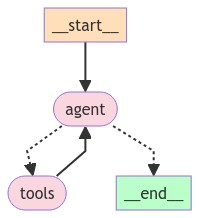

In [9]:
import * as tslab from "tslab";

const drawableGraph = app.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

我们来尝试一下吧！

In [10]:
import { HumanMessage } from "@langchain/core/messages";

// 单个工具调用的示例
const stream = await app.stream(
  {
    messages: [{ role: "user", content: "what's the weather in sf?" }],
  },
  {
    streamMode: "values"
  }
)
for await (const chunk of stream) {
  const lastMessage = chunk.messages[chunk.messages.length - 1];
  const type = lastMessage._getType();
  const content = lastMessage.content;
  const toolCalls = lastMessage.tool_calls;
  console.dir({
    type,
    content,
    toolCalls
  }, { depth: null });
}

{
  type: 'human',
  content: "what's the weather in sf?",
  toolCalls: undefined
}
{
  type: 'ai',
  content: [
    { type: 'text', text: "Okay, let's check the weather in SF:" },
    {
      type: 'tool_use',
      id: 'toolu_01X5yTzVrGZqNz9vf1w2MCna',
      name: 'get_weather',
      input: { location: 'sf' }
    }
  ],
  toolCalls: [
    {
      name: 'get_weather',
      args: { location: 'sf' },
      id: 'toolu_01X5yTzVrGZqNz9vf1w2MCna',
      type: 'tool_call'
    }
  ]
}
{
  type: 'tool',
  content: "It's 60 degrees and foggy.",
  toolCalls: undefined
}
{
  type: 'ai',
  content: 'The current weather in San Francisco is 60 degrees and foggy.',
  toolCalls: []
}


In [11]:
// 连续调用多个工具的示例
const streamWithMultiToolCalls = await app.stream(
  {
      messages: [{ role: "user", content: "what's the weather in the coolest cities?" }],
  },
  {
    streamMode: "values"
  }
)
for await (const chunk of streamWithMultiToolCalls) {
  const lastMessage = chunk.messages[chunk.messages.length - 1];
  const type = lastMessage._getType();
  const content = lastMessage.content;
  const toolCalls = lastMessage.tool_calls;
  console.dir({
    type,
    content,
    toolCalls
  }, { depth: null });
}

{
  type: 'human',
  content: "what's the weather in the coolest cities?",
  toolCalls: undefined
}
{
  type: 'ai',
  content: [
    {
      type: 'text',
      text: "Okay, let's find out the weather in the coolest cities:"
    },
    {
      type: 'tool_use',
      id: 'toolu_017RHcsJFeo7w6kDnZ6TAa19',
      name: 'get_coolest_cities',
      input: { noOp: 'dummy' }
    }
  ],
  toolCalls: [
    {
      name: 'get_coolest_cities',
      args: { noOp: 'dummy' },
      id: 'toolu_017RHcsJFeo7w6kDnZ6TAa19',
      type: 'tool_call'
    }
  ]
}
{ type: 'tool', content: 'nyc, sf', toolCalls: undefined }
{
  type: 'ai',
  content: [
    {
      type: 'text',
      text: "Now let's get the weather for those cities:"
    },
    {
      type: 'tool_use',
      id: 'toolu_01ML1jW5u5aVCFkZhihzLv24',
      name: 'get_weather',
      input: { location: 'nyc' }
    }
  ],
  toolCalls: [
    {
      name: 'get_weather',
      args: { location: 'nyc' },
      id: 'toolu_01ML1jW5u5aVCFkZhihzLv24',
   

`ToolNode` 还可以处理工具执行期间的错误。请参阅`ToolNode`[此处](/langgraphjs/how-tos/tool-calling-errors/)中的错误处理指南。